<a href="https://colab.research.google.com/github/larissavaladao/py6s_harmonize_sample/blob/main/6.%20parameters_by_period/area_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd
import pandas as pd
import math
import ee
import geemap

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import image collections

Landsat 7 - PY6S

In [4]:
landsat7 = ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD7/ld7_py6s")\
            .select([ 'B1', 'B2', 'B3', 'B4', 'B5', 'B7'])
print(ee.Date(landsat7.first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat7.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2013-05-12T13:44:05
2017-09-28T13:50:48


In [45]:
print(landsat7.aggregate_histogram('WRS_PATH').getInfo())
print(landsat7.aggregate_histogram('WRS_ROW').getInfo())

{'227.0': 64, '228.0': 138}
{'61.0': 73, '62.0': 129}


In [49]:
print(landsat7.filter(ee.Filter.eq('WRS_PATH',227.0)).aggregate_histogram('WRS_ROW').getInfo())
print(landsat7.filter(ee.Filter.eq('WRS_PATH',228.0)).aggregate_histogram('WRS_ROW').getInfo())

{'62.0': 64}
{'61.0': 73, '62.0': 65}


Landsat 8 PY6S

In [5]:
landsat8 = (ee.ImageCollection("projects/ee-curuai/assets/Py6S/LD8/ld8_py6s")
            .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7']))
print(ee.Date(landsat8.first().get('system:time_start')).format().getInfo())
print(ee.Date(landsat8.sort('system:time_start',False).first().get('system:time_start')).format().getInfo())

2013-05-20T13:50:14
2017-09-27T13:54:12


In [53]:
print(landsat8.aggregate_histogram('WRS_PATH').getInfo())
print(landsat8.aggregate_histogram('WRS_ROW').getInfo())

{'227.0': 69, '228.0': 139}
{'61.0': 76, '62.0': 132}


In [54]:
print(landsat7.filter(ee.Filter.eq('WRS_PATH',227.0)).aggregate_histogram('WRS_ROW').getInfo())
print(landsat7.filter(ee.Filter.eq('WRS_PATH',228.0)).aggregate_histogram('WRS_ROW').getInfo())

{'62.0': 64}
{'61.0': 73, '62.0': 65}


# Transform into remote sensing reflectance and sunglint correction

In [6]:
def deglint (img):
  '''#dividir imagem corrigida por pi
  Rrs_sat_ac = Rsat_ac / pi
  fazer deglint
  Rrs_sat_ac_deglint(VNIR) = Rrs_sat_ac (VNIR) − Rrs_sat_ac (SWIR)
  correção no artigo INPE CURUAI'''
  Rrs = img.divide(math.pi)
  deglint = Rrs.select(['blue_mean','green_mean','red_mean','nir_mean','swir1','swir2'])\
    .subtract(Rrs.select('swir1'))

  return (deglint.updateMask(deglint.select(['red_mean']).gt(0)).updateMask(deglint.select(['blue_mean']).gt(0)).updateMask(deglint.select(['green_mean']).gt(0)).updateMask(deglint.select(['nir_mean']).gt(0))
          .copyProperties(img,['system:time_start','CLOUD_COVER',"system:index"]))

## Padronize band names

In [7]:
name_bands = ['blue_mean','green_mean','red_mean','nir_mean','swir1','swir2']

Landsat 7

In [8]:
#renomear bandas

ld7 = landsat7.map(lambda img: img.rename(name_bands)).map(deglint)
ld7.first()

Landsat 8

In [9]:
ld8 = landsat8.map(lambda img: img.rename(name_bands)).map(deglint)
ld8

# Mask land

In [55]:
def hsvComposite (image):
    composite = image.select(['blue_mean','green_mean','red_mean']).rgbToHsv()#.clip(limits);
    hue = composite.select("hue");
    max_mask = hue.lte(0.9)
    min_mask = hue.gte(0.3)
    return image.updateMask(max_mask).updateMask(min_mask).select(['blue_mean','green_mean','red_mean','nir_mean']);

In [56]:
land_mask_ld8 = ld8.map(hsvComposite)
land_mask_ld7 = ld7.map(hsvComposite)

# Fazer mosaico por periodo da água

In [ ]:
#se 228 61 então pode usar a imagem inteira para calcular área
#se 228 62 então tem que somar com 228 61 para calcular área

#calculate area

In [38]:
def area_calc(img):
  '''receives an image of curuai and returns water surface area in km2 within the floodplain limits
  as a property of the input image'''

  # Get a pixel area image.
  pixel_area = ee.Image.pixelArea()

  floodplain = ee.FeatureCollection('projects/ee-curuai/assets/vectors/varzea_alagavel')
  image = hsvComposite(img)
  img_mask = image.gt(0)

  areaImage = img_mask.multiply(pixel_area)

  area = areaImage.reduceRegion(**{
    'reducer': ee.Reducer.sum(),
    'geometry': floodplain.geometry(),
    'scale': 30,
    'maxPixels': 1e10
    })
  return image.set('area_km2',ee.Number(area.get('red_mean')).divide(1e6))


In [40]:
img_area_ld8 = ld8.map(area_calc)
img_area_ld7 = ld7.map(area_calc)
img_area_ld7.first()

# Import Model and Classify Images

In [33]:
classifier = ee.Classifier.load('projects/ee-curuai/assets/RF_regressor')
classifier

In [ ]:
predictors = ['blue_mean', 'green_mean','red_mean', 'nir_mean']
ld7_classified = ld7_masked.select(predictors).map(lambda img: img.classify(classifier=classifier).copyProperties(img,['system:index','system:time_start']))
ld7_classified

In [ ]:
ld8_classified = ld8_masked.select(predictors).map(lambda img: img.classify(classifier=classifier).copyProperties(img,['system:index','system:time_start']))
ld8_classified

#Classification vizualization

## Import Points

In [ ]:
# points used for regression
reg_points = geemap.geojson_to_ee('/content/drive/MyDrive/CURUAI_PROCESS/regression_p.geojson')
reg_points_unique = reg_points.distinct('.geo')
reg_points_unique


## Sample images from regression points

In [ ]:
projection = ld8.first().select('red_mean').projection()

In [ ]:
ld7_sample = (ld7_classified
              .map(lambda img: img.addBands(ee.Image(ee.Number(img.get('system:time_start')))).rename(['SPM_img','img_date']))
              .map(lambda img: img.sampleRegions(collection = reg_points_unique, scale=30, projection=projection,geometries=False))
              .flatten()
              .map(lambda feat: feat.set('img_datetime',ee.Date(feat.get('img_date')).format('yyyy-MM-dd HH:mm:ss'))))
ld7_sample.select(['SPM_img','img_datetime']).limit(10)

In [ ]:
ld8_sample = (ld8_classified
              .map(lambda img: img.addBands(ee.Image(ee.Number(img.get('system:time_start')))).rename(['SPM_img','img_date']))
              .map(lambda img: img.sampleRegions(collection = reg_points_unique, scale=30, projection=projection,geometries=False))
              .flatten()
              .map(lambda feat: feat.set('img_datetime',ee.Date(feat.get('img_date')).format('yyyy-MM-dd HH:mm:ss'))))
ld8_sample.select(['SPM_img','img_datetime']).size()

In [ ]:
obs_points = gpd.read_file('/content/drive/MyDrive/CURUAI_PROCESS/regression_p.geojson')
obs_points

,LATITUDE,LONGITUDE,SPM,SPM_predicted,WATER_PERIOD,blue_mean,datetime,green_mean,nir_mean,red_mean,geometry
0,-2.196960,-55.299530,34.40,54.698376,R,0.016988,2013-03-09 11:20:00,0.027905,0.016161,0.036151,POINT (-55.29953 -2.19696)
1,-2.221738,-55.270194,44.40,47.285001,R,0.017570,2013-03-09 13:00:00,0.029232,0.013234,0.034852,POINT (-55.27019 -2.22174)
2,-2.209570,-55.347110,44.80,36.468949,R,0.014560,2013-03-09 14:35:00,0.020075,0.010206,0.024131,POINT (-55.34711 -2.20957)
3,-2.262023,-55.456187,45.20,65.154042,R,0.031565,2013-03-11 08:00:00,0.039040,0.020332,0.043538,POINT (-55.45619 -2.26202)
4,-2.133265,-55.488798,39.20,44.829901,R,0.021785,2013-03-11 13:00:00,0.032779,0.014011,0.038842,POINT (-55.4888 -2.13326)
...,...,...,...,...,...,...,...,...,...,...,...
182,-2.180361,-55.016444,57.00,62.350335,HW,0.019383,2017-04-10 18:00:00,0.033635,0.016626,0.046282,POINT (-55.01644 -2.18036)
183,-2.173257,-55.372851,14.50,21.803986,HW,0.014880,2017-04-11 14:30:00,0.021639,0.005093,0.024721,POINT (-55.37285 -2.17326)
184,-2.135144,-55.370602,19.00,23.679412,HW,0.012534,2017-04-11 15:15:00,0.020394,0.004060,0.023798,POINT (-55.3706 -2.13514)
185,-2.113672,-55.370602,25.75,28.166720,HW,0.004243,2017-04-11 15:50:00,0.014249,0.007008,0.018634,POINT (-55.3706 -2.11367)


In [ ]:
ld8_pred = ee.data.computeFeatures({
    'expression': ld8_sample.select(['SPM_img','img_datetime']),
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [ ]:
ld7_pred = ee.data.computeFeatures({
    'expression': ld7_sample.select(['SPM_img','img_datetime']),
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [ ]:
ld7_pred = ld7_pred.astype({'SPM_img': 'float64'})
ld8_pred = ld8_pred.astype({'SPM_img': 'float64'})


In [ ]:
ld7_pred['img_datetime']= pd.to_datetime(ld7_pred['img_datetime'])
ld8_pred['img_datetime']= pd.to_datetime(ld8_pred['img_datetime'])

In [ ]:
df_pred = pd.concat([ld7_pred,ld8_pred]).sort_values('img_datetime')
df_pred.dtypes

,0
geo,object
SPM_img,float64
img_datetime,datetime64[ns]


In [ ]:
df_pred

,geo,SPM_img,img_datetime
152,None,50.771477,2013-03-16 13:50:07
148,None,81.416534,2013-03-16 13:50:07
149,None,50.771477,2013-03-16 13:50:07
150,None,50.674473,2013-03-16 13:50:07
151,None,63.578747,2013-03-16 13:50:07
...,...,...,...
6009,None,26.321892,2017-09-19 13:56:58
6000,None,50.480186,2017-09-19 13:56:58
126,None,33.177132,2017-09-28 13:50:48
125,None,93.894180,2017-09-28 13:50:48


<Axes: xlabel='img_datetime', ylabel='SPM_img'>

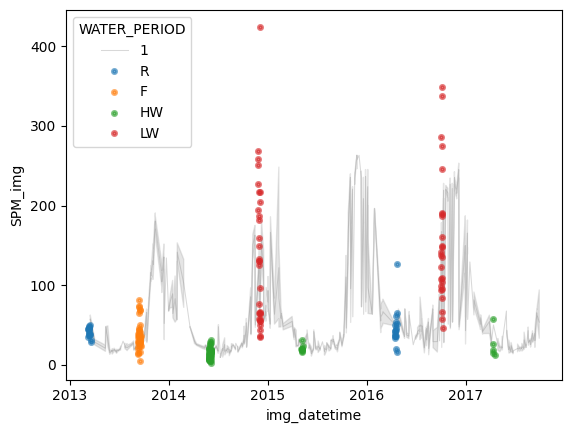

In [ ]:
import seaborn as sns
sns.lineplot(data=df_pred, x ='img_datetime',y= 'SPM_img',  alpha=.3,color='gray',size=1)
sns.pointplot(data=obs_points, x ='datetime',y= 'SPM',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=True)

In [ ]:
Map = geemap.Map(basemap='HYBRID')
roi_points = ee.FeatureCollection('projects/ee-curuai/assets/curuai_points')
Map.centerObject(roi_points,10)
imgld7 = ee.Filter.eq('system:index','BOA_LE07_228061_20130604')
imgld8 = ee.Filter.eq('system:index','BOA_LC08_228061_20140615')

Map.addLayer(ld7.filter(imgld7).first(), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'ld7')
Map.addLayer(ld8.filter(imgld8).first(), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'ld8')

Map.addLayer(ld7_masked.filter(imgld7).first(), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'ld7 masked')
Map.addLayer(ld8_masked.filter(imgld8).first(), {'bands':['red_mean','green_mean','blue_mean'], 'min':0,'max':0.02}, 'ld8 masked')


Map.addLayer(ld7_classified.filter(imgld7).first(), {'palette':['#ffffb2','#fecc5c','#fd8d3c','#e31a1c'], 'min':0,'max':150}, 'classification LD7')
Map.addLayer(ld8_classified.filter(imgld8).first(), {'palette':['#ffffb2','#fecc5c','#fd8d3c','#e31a1c'], 'min':0,'max':150}, 'classification LD8')

Map.addLayer(varzea_gee,{'color':'red'},'limite varzea alagavel')

Map.addLayer(roi_points, {'color':'darkred'}, 'Data polygon');
Map

Map(center=[-2.184599717160098, -55.49304633852027], controls=(WidgetControl(options=['position', 'transparent…